# 对比试验
目的是证明VG距离,WVG距离优于欧式距离,更能反应原序列的变动对查找与query相似的序列的影响
1.比对VG距离,WVG距离,欧氏距离,在 100对不同长度的等长序列query与需匹配的b(query!=b) 中, 当对b施加随机强度的噪声时,各距离计算方式下新距离与原距离的比值,目的是探究不同长度的模体发现下,这3中距离计算方式的优劣,可能需要分别讨论是否需标准化
2.在100对等长的query与b里,对b施加不同强度的噪声,用于探究噪声强度对不同距离计算方式的影响
# 参数选择推荐
对100对随机生成的query与b(query=b)里,对b施加不同强度的噪声,计算每个强度下的平均VG距离变化量,用于推荐 什么水平的VG距离能代表query与b相似,什么水平是不相似的

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from fastdtw import dtw as dtw
from core import *


In [2]:
#实现基于度序列的度量
def _convert_2_row_vector(TS) ->np.ndarray:
    """
    将能转为行向量的转为行向量
    :param TS:时间序列
    :return:行向量版TS
    """
    if not isinstance(TS,np.ndarray):
        TS=np.asarray(TS)
    _shape = TS.shape
    if TS.ndim == 1:
        return TS.reshape([1, _shape[0]])
    if TS.ndim == 2:
        if _shape[0] == 1:
            return TS
        if _shape[1] == 1:
            return TS.T
    raise f"仅允许输入能转为行向量的时间序列,而目前输入了shape={TS.shape}"


def _fastVG(TS: np.ndarray, window: int):
    """
    用于生成TS的有限视距的VG网络
    通过错位相减等向量计算法加速VG序列的生成
    :param TS: 能转为行向量的时间序列
    :return: (_len-2)*(window-2)的变种邻接矩阵A,A的i,j处的值:表示ts的VG网络中节点i与i+j+2是否存在连边，True为有
    """

    _len = TS.shape[1]
    res = np.full([window,window],np.False_)
    max_k = np.full([1, _len], np.NINF)
    for i in range(1, window):
        k = (TS[0, i:] - TS[0, :-i]) / i
        index = k > max_k[0,:-i]
        where_is_true=np.where(index)[0]
        max_k[0,where_is_true] = k[index]
        for j in where_is_true:
            res[j,j+i]=True
            res[j+i,j]=True
    return res
def compare_two_TS_by_degree(TS1,TS2):
    TS1,TS2=_convert_2_row_vector(TS1),_convert_2_row_vector(TS2)
    VG1,VG2=_fastVG(TS1,TS1.shape[1]),_fastVG(TS2,TS2.shape[1])
    degree1,degree2=np.sum(VG1,axis=0),np.sum(VG2,axis=0)
    return np.linalg.norm(degree1-degree2)

In [19]:
a=[2,7,4,2]
b=[1,5,1]
# a,b=_convert_2_row_vector(a),_convert_2_row_vector(b)
# print(b.reshape(-1))
# a=np.random.randn(1,10)
print(dtw(a,b,2))

(5.0, [(0, 0), (1, 1), (2, 1), (3, 2)])


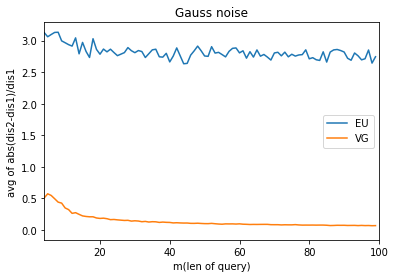

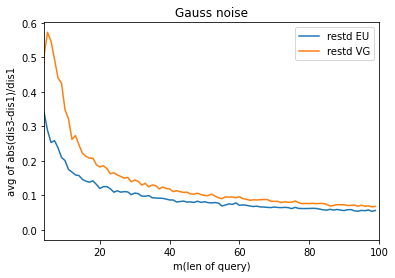

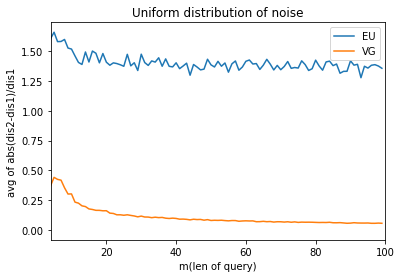

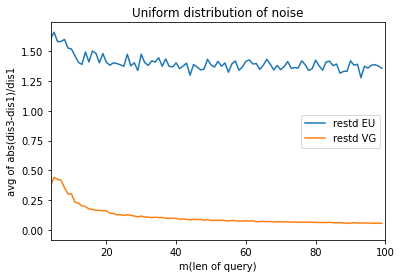

In [11]:
eu_res=np.zeros(100)
vg_res=np.zeros(100)
std_eu_res=np.zeros(100)
std_vg_res=np.zeros(100)
for m in range(3,100):
    eu_temp=[]
    vg_temp=[]
    std_eu_temp=[]
    std_vg_temp=[]
    for i in range(1000):
        query=np.random.randn(1,m)
        b=np.random.randn(1,m)
        c=np.random.randn(1,m)*np.random.uniform(0,10)
        b2=b+c
        eu_dis1=np.linalg.norm(query-b)
        eu_dis2=np.linalg.norm(query-b2)
        vg_dis1=compare_two_TS(query,b)
        if vg_dis1==0:
            continue
        vg_dis2=compare_two_TS(query,b2)
        eu_temp.append(abs(eu_dis2-eu_dis1)/eu_dis1)
        vg_temp.append(abs(vg_dis2-vg_dis1)/vg_dis1)

        b2=(b2-b2.mean())/b2.std()
        eu_dis2=np.linalg.norm(query-b2)
        vg_dis2=compare_two_TS(query,b2)
        std_eu_temp.append(abs(eu_dis2-eu_dis1)/eu_dis1)
        std_vg_temp.append(abs(vg_dis2-vg_dis1)/vg_dis1)
        # # if diff >0:
        # #     print(m,i)
        # vg_temp[i]=diff
    # print(m-3)
    eu_res[m]=np.mean(eu_temp)
    vg_res[m]=np.mean(vg_temp)
    std_eu_res[m]=np.mean(std_eu_temp)
    std_vg_res[m]=np.mean(std_vg_temp)
plt.figure()
plt.plot(eu_res,label="EU")
plt.plot(vg_res,label="VG")
plt.xlim(4,100)
plt.legend()
plt.xlabel('m(len of query)')
plt.ylabel('avg of abs(dis2-dis1)/dis1')
plt.title("Gauss noise")
plt.savefig('不同m下随机强度的高斯噪声对序列间距离的影响.svg')
plt.show()

plt.figure()
plt.plot(std_eu_res,label="restd EU")
plt.plot(std_vg_res,label="restd VG")
plt.xlim(4,100)
plt.legend()
plt.xlabel('m(len of query)')
plt.ylabel('avg of abs(dis3-dis1)/dis1')
plt.title("Gauss noise")
plt.savefig('不同m下随机强度的高斯噪声对再次标准化序列间距离的影响.svg')
plt.show()

eu_res=np.zeros(100)
vg_res=np.zeros(100)
std_eu_res=np.zeros(100)
std_vg_res=np.zeros(100)
for m in range(3,100):
    eu_temp=[]
    vg_temp=[]
    std_eu_temp=[]
    std_vg_temp=[]
    for i in range(1000):
        noise_db=np.random.uniform(0,10)
        query=np.random.randn(1,m)
        b=np.random.randn(1,m)
        c=np.random.rand(1,m)*noise_db
        # print(f'nd:{noise_db},c:{c}')
        b2=b+c
        eu_dis1=np.linalg.norm(query-b)
        eu_dis2=np.linalg.norm(query-b2)
        vg_dis1=compare_two_TS(query,b)
        if vg_dis1==0:
            continue
        vg_dis2=compare_two_TS(query,b2)
        eu_temp.append(abs(eu_dis2-eu_dis1)/eu_dis1)
        vg_temp.append(abs(vg_dis2-vg_dis1)/vg_dis1)

        b2=(b2-b2.mean())/b2.std()
        eu_dis2=np.linalg.norm(query-b2)
        vg_dis2=compare_two_TS(query,b2)
        std_eu_temp.append(abs(eu_dis2-eu_dis1)/eu_dis1)
        std_vg_temp.append(abs(vg_dis2-vg_dis1)/vg_dis1)
    # print(m-3)
    eu_res[m]=np.mean(eu_temp)
    vg_res[m]=np.mean(vg_temp)
    std_eu_res[m]=np.mean(std_eu_temp)
    std_vg_res[m]=np.mean(std_vg_temp)
plt.figure()
plt.plot(eu_res,label="EU")
plt.plot(vg_res,label="VG")
plt.xlim(4,100)
plt.legend()
plt.xlabel('m(len of query)')
plt.ylabel('avg of abs(dis2-dis1)/dis1')
plt.title("Uniform distribution of noise")
plt.savefig('不同m下随机强度的均匀分布噪声对序列间距离的影响.svg')
plt.show()

plt.figure()
plt.plot(std_eu_res,label="restd EU")
plt.plot(std_vg_res,label="restd VG")
plt.xlim(4,100)
plt.legend()
plt.xlabel('m(len of query)')
plt.ylabel('avg of abs(dis3-dis1)/dis1')
plt.title("Uniform distribution of noise")
plt.savefig('不同m下随机强度的均匀分布噪声对再次标准化的序列间距离的影响.svg')
plt.show()

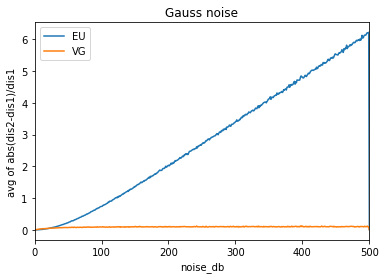

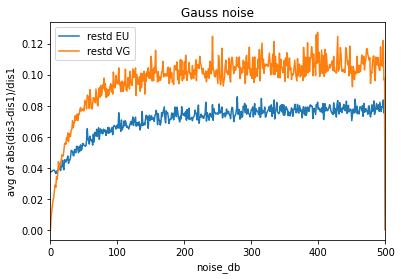

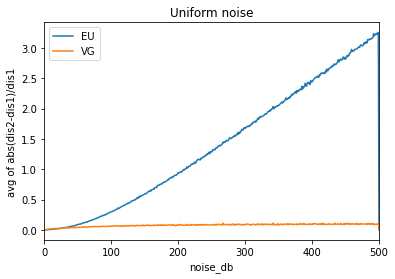

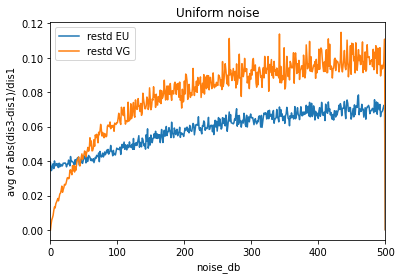

In [15]:
eu_res=np.zeros(1000)
vg_res=np.zeros(1000)
std_eu_res=np.zeros(1000)
std_vg_res=np.zeros(1000)
for j in range(500):
    noise_db=j/50
    eu_temp=[]
    vg_temp=[]
    std_eu_temp=[]
    std_vg_temp=[]
    for i in range(1000):
        m=np.random.randint(3,200)
        query=np.random.randn(1,m)
        b=np.random.randn(1,m)
        c=np.random.randn(1,m)*noise_db
        b2=b+c
        # print(f"""m:{m}
        #         q:{query}
        #         c:{c}""")
        vg_dis1=compare_two_TS(query,b)
        if vg_dis1==0:
            continue
        vg_dis=compare_two_TS(query,b2)
        eu_dis1=np.linalg.norm(query-b)
        eu_dis2=np.linalg.norm(query-b2)
        vg_dis2=compare_two_TS(query,b2)
        eu_temp.append(abs(eu_dis2-eu_dis1)/eu_dis1)
        vg_temp.append(abs(vg_dis2-vg_dis1)/vg_dis1)

        b2=(b2-b2.mean())/b2.std()
        eu_dis2=np.linalg.norm(query-b2)
        vg_dis2=compare_two_TS(query,b2)
        std_eu_temp.append(abs(eu_dis2-eu_dis1)/eu_dis1)
        std_vg_temp.append(abs(vg_dis2-vg_dis1)/vg_dis1)
    # print(m-3)
    eu_res[j]=np.mean(eu_temp)
    vg_res[j]=np.mean(vg_temp)
    std_eu_res[j]=np.mean(std_eu_temp)
    std_vg_res[j]=np.mean(std_vg_temp)
plt.figure()
plt.plot(eu_res,label="EU")
plt.plot(vg_res,label="VG")
plt.xlim(0,500)
plt.legend()
plt.xlabel('noise_db')
plt.ylabel('avg of abs(dis2-dis1)/dis1')
plt.title("Gauss noise")
plt.savefig('不同强度的高斯噪声下对随机m长序列间距离的影响.svg')
plt.show()

plt.figure()
plt.plot(std_eu_res,label="restd EU")
plt.plot(std_vg_res,label="restd VG")
plt.xlim(0,500)
plt.legend()
plt.xlabel('noise_db')
plt.ylabel('avg of abs(dis3-dis1)/dis1')
plt.title("Gauss noise")
plt.savefig('不同强度的高斯噪声下对随机m长序列再次标准化后的距离的影响.svg')
plt.show()

eu_res=np.zeros(1000)
vg_res=np.zeros(1000)
std_eu_res=np.zeros(1000)
std_vg_res=np.zeros(1000)
for j in range(500):
    noise_db=j/50
    eu_temp=[]
    vg_temp=[]
    std_eu_temp=[]
    std_vg_temp=[]
    for i in range(1000):
        m=np.random.randint(3,200)
        query=np.random.randn(1,m)
        b=np.random.randn(1,m)
        c=np.random.uniform(0,noise_db,[1,m])
        b2=b+c
        vg_dis1=compare_two_TS(query,b)
        if vg_dis1==0:
            continue
        vg_dis=compare_two_TS(query,b2)
        eu_dis1=np.linalg.norm(query-b)
        eu_dis2=np.linalg.norm(query-b2)
        vg_dis2=compare_two_TS(query,b2)
        eu_temp.append(abs(eu_dis2-eu_dis1)/eu_dis1)
        vg_temp.append(abs(vg_dis2-vg_dis1)/vg_dis1)

        b2=(b2-b2.mean())/b2.std()
        eu_dis2=np.linalg.norm(query-b2)
        vg_dis2=compare_two_TS(query,b2)
        std_eu_temp.append(abs(eu_dis2-eu_dis1)/eu_dis1)
        std_vg_temp.append(abs(vg_dis2-vg_dis1)/vg_dis1)
    # print(m-3)
    eu_res[j]=np.mean(eu_temp)
    vg_res[j]=np.mean(vg_temp)
    std_eu_res[j]=np.mean(std_eu_temp)
    std_vg_res[j]=np.mean(std_vg_temp)
plt.figure()
plt.plot(eu_res,label="EU")
plt.plot(vg_res,label="VG")
plt.xlim(0,500)
plt.legend()
plt.xlabel('noise_db')
plt.ylabel('avg of abs(dis2-dis1)/dis1')
plt.title("Uniform noise")
plt.savefig('不同强度的均匀分布噪声下对随机m长序列间距离的影响.svg')
plt.show()

plt.figure()
plt.plot(std_eu_res,label="restd EU")
plt.plot(std_vg_res,label="restd VG")
plt.xlim(0,500)
plt.legend()
plt.xlabel('noise_db')
plt.ylabel('avg of abs(dis3-dis1)/dis1')
plt.title("Uniform noise")
plt.savefig('不同强度的均匀分布噪声下对随机m长序列再次标准化后的距离的影响.svg')
plt.show()

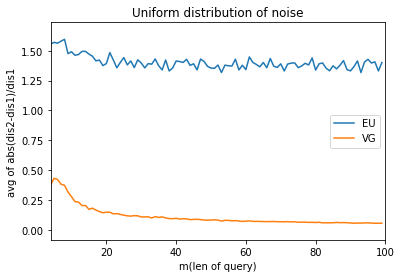

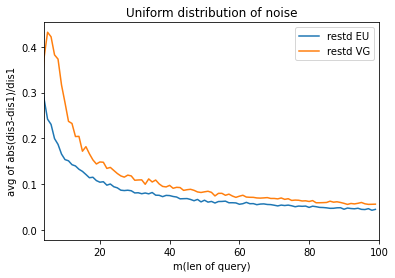

In [13]:
eu_res=np.zeros(100)
vg_res=np.zeros(100)
std_eu_res=np.zeros(100)
std_vg_res=np.zeros(100)
for m in range(3,100):
    eu_temp=[]
    vg_temp=[]
    std_eu_temp=[]
    std_vg_temp=[]
    for i in range(1000):
        noise_db=np.random.uniform(0,10)
        query=np.random.randn(1,m)
        b=np.random.randn(1,m)
        c=np.random.rand(1,m)*noise_db
        # print(f'nd:{noise_db},c:{c}')
        b2=b+c
        eu_dis1=np.linalg.norm(query-b)
        eu_dis2=np.linalg.norm(query-b2)
        vg_dis1=compare_two_TS(query,b)
        if vg_dis1==0:
            continue
        vg_dis2=compare_two_TS(query,b2)
        eu_temp.append(abs(eu_dis2-eu_dis1)/eu_dis1)
        vg_temp.append(abs(vg_dis2-vg_dis1)/vg_dis1)

        b2=(b2-b2.mean())/b2.std()
        eu_dis2=np.linalg.norm(query-b2)
        vg_dis2=compare_two_TS(query,b2)
        std_eu_temp.append(abs(eu_dis2-eu_dis1)/eu_dis1)
        std_vg_temp.append(abs(vg_dis2-vg_dis1)/vg_dis1)
    # print(m-3)
    eu_res[m]=np.mean(eu_temp)
    vg_res[m]=np.mean(vg_temp)
    std_eu_res[m]=np.mean(std_eu_temp)
    std_vg_res[m]=np.mean(std_vg_temp)
plt.figure()
plt.plot(eu_res,label="EU")
plt.plot(vg_res,label="VG")
plt.xlim(4,100)
plt.legend()
plt.xlabel('m(len of query)')
plt.ylabel('avg of abs(dis2-dis1)/dis1')
plt.title("Uniform distribution of noise")
plt.savefig('不同m下随机强度的均匀分布噪声对序列间距离的影响.svg')
plt.show()

plt.figure()
plt.plot(std_eu_res,label="restd EU")
plt.plot(std_vg_res,label="restd VG")
plt.xlim(4,100)
plt.legend()
plt.xlabel('m(len of query)')
plt.ylabel('avg of abs(dis3-dis1)/dis1')
plt.title("Uniform distribution of noise")
plt.savefig('不同m下随机强度的均匀分布噪声对再次标准化的序列间距离的影响.svg')
plt.show()

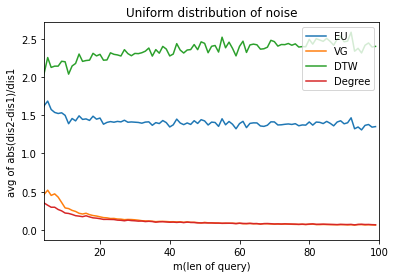

In [5]:
# eu_res=np.zeros(100)
# vg_res=np.zeros(100)
# dtw_res=np.zeros(100)
# degree_res=np.zeros(100)
# for m in range(3,100):
#     eu_temp=[]
#     vg_temp=[]
#     dtw_temp=[]
#     degree_temp=[]
#     for i in range(1000):
#         query=np.random.randn(1,m)
#         b=np.random.randn(1,m)
#         c=np.random.randn(1,m)*np.random.uniform(0,10)
#         b2=b+c
#         vg_dis1=compare_two_TS(query,b)
#         vg_dis2=compare_two_TS(query,b2)
#         if vg_dis1==0:
#             continue
#         eu_dis1=np.linalg.norm(query-b)
#         eu_dis2=np.linalg.norm(query-b2)
#
#         dtw_dis1=dtw(query.reshape(-1),b.reshape(-1))[0]
#         dtw_dis2=dtw(query.reshape(-1),b2.reshape(-1))[0]
#
#         degree_dis1=compare_two_TS_by_degree(query,b)
#         degree_dis2=compare_two_TS_by_degree(query,b2)
#
#         eu_temp.append(abs(eu_dis2-eu_dis1)/eu_dis1)
#         vg_temp.append(abs(vg_dis2-vg_dis1)/vg_dis1)
#         dtw_temp.append(abs(dtw_dis2-dtw_dis1)/dtw_dis1)
#         degree_temp.append(abs(degree_dis1-degree_dis2)/degree_dis1)
#
#     eu_res[m]=np.mean(eu_temp)
#     vg_res[m]=np.mean(vg_temp)
#     dtw_res[m]=np.mean(dtw_temp)
#     degree_res[m]=np.mean(degree_temp)
# plt.figure()
# plt.plot(eu_res,label="EU")
# plt.plot(vg_res,label="VG")
# plt.plot(dtw_res,label="DTW")
# plt.plot(degree_res,label="Degree")
# plt.xlim(4,100)
# # plt.ylim(0,5)
# plt.legend()
# plt.xlabel('m(len of query)')
# plt.ylabel('avg of abs(dis2-dis1)/dis1')
# plt.title("Gauss noise")
# plt.savefig('fig/不同m下随机强度的高斯噪声对序列间距离的影响.svg')
# plt.show()

eu_res=np.zeros(100)
vg_res=np.zeros(100)
dtw_res=np.zeros(100)
degree_res=np.zeros(100)
for m in range(3,100):
    eu_temp=[]
    vg_temp=[]
    dtw_temp=[]
    degree_temp=[]
    for i in range(1000):
        noise_db=np.random.uniform(0,10)
        query=np.random.randn(1,m)
        b=np.random.randn(1,m)
        c=np.random.uniform(-noise_db,noise_db,[1,m])
        # print(f'nd:{noise_db},c:{c}')
        b2=b+c
        vg_dis1=compare_two_TS(query,b)
        vg_dis2=compare_two_TS(query,b2)
        if vg_dis1==0:
            continue
        eu_dis1=np.linalg.norm(query-b)
        eu_dis2=np.linalg.norm(query-b2)

        dtw_dis1=dtw(query.reshape(-1),b.reshape(-1))[0]
        dtw_dis2=dtw(query.reshape(-1),b2.reshape(-1))[0]

        degree_dis1=compare_two_TS_by_degree(query,b)
        degree_dis2=compare_two_TS_by_degree(query,b2)

        eu_temp.append(abs(eu_dis2-eu_dis1)/eu_dis1)
        vg_temp.append(abs(vg_dis2-vg_dis1)/vg_dis1)
        dtw_temp.append(abs(dtw_dis2-dtw_dis1)/dtw_dis1)
        degree_temp.append(abs(degree_dis1-degree_dis2)/degree_dis1)

    eu_res[m]=np.mean(eu_temp)
    vg_res[m]=np.mean(vg_temp)
    dtw_res[m]=np.mean(dtw_temp)
    degree_res[m]=np.mean(degree_temp)
plt.figure()
plt.plot(eu_res,label="EU")
plt.plot(vg_res,label="VG")
plt.plot(dtw_res,label="DTW")
plt.plot(degree_res,label="Degree")
plt.xlim(4,100)
# plt.ylim(0,5)
plt.legend()
plt.xlabel('m(len of query)')
plt.ylabel('avg of abs(dis2-dis1)/dis1')
plt.title("Uniform distribution of noise")
plt.savefig('fig/不同m下随机强度的均匀分布噪声对序列间距离的影响.svg')
plt.show()



In [4]:
eu_res=np.zeros(500)
vg_res=np.zeros(500)
dtw_res=np.zeros(500)
degree_res=np.zeros(500)
for j in range(500):
    noise_db=j/100
    eu_temp=[]
    vg_temp=[]
    dtw_temp=[]
    degree_temp=[]
    for i in range(1000):
        m=np.random.randint(4,200)
        query=np.random.randn(1,m)
        b=np.random.randn(1,m)
        c=np.random.randn(1,m)*noise_db
        b2=b+c
        vg_dis1=compare_two_TS(query,b)
        vg_dis2=compare_two_TS(query,b2)
        if vg_dis1==0:
            continue
        eu_dis1=np.linalg.norm(query-b)
        eu_dis2=np.linalg.norm(query-b2)

        dtw_dis1=dtw(query.reshape(-1),b.reshape(-1))[0]
        dtw_dis2=dtw(query.reshape(-1),b2.reshape(-1))[0]

        degree_dis1=compare_two_TS_by_degree(query,b)
        degree_dis2=compare_two_TS_by_degree(query,b2)

        eu_temp.append(abs(eu_dis2-eu_dis1)/eu_dis1)
        vg_temp.append(abs(vg_dis2-vg_dis1)/vg_dis1)
        dtw_temp.append(abs(dtw_dis2-dtw_dis1)/dtw_dis1)
        degree_temp.append(abs(degree_dis1-degree_dis2)/degree_dis1)

    eu_res[j]=np.mean(eu_temp)
    vg_res[j]=np.mean(vg_temp)
    dtw_res[j]=np.mean(dtw_temp)
    degree_res[j]=np.mean(degree_temp)
plt.figure()
plt.plot(eu_res,label="EU")
plt.plot(vg_res,label="VG")
plt.plot(dtw_res,label="DTW")
plt.plot(degree_res,label="Degree")
# plt.xlim(4,100)
plt.ylim(0,5)
plt.legend()
plt.xlabel('noise_db')
plt.ylabel('avg of abs(dis2-dis1)/dis1')
plt.title("Gauss noise")
plt.savefig('fig/不同强度的高斯噪声下对随机m长序列的距离的影响.svg')
plt.show()

eu_res=np.zeros(500)
vg_res=np.zeros(500)
dtw_res=np.zeros(500)
degree_res=np.zeros(500)
for j in range(500):
    noise_db=j/100
    eu_temp=[]
    vg_temp=[]
    dtw_temp=[]
    degree_temp=[]
    for i in range(1000):
        m=np.random.randint(4,200)
        query=np.random.randn(1,m)
        b=np.random.randn(1,m)
        c=np.random.rand(1,m)*noise_db
        # print(f'nd:{noise_db},c:{c}')
        b2=b+c
        vg_dis1=compare_two_TS(query,b)
        vg_dis2=compare_two_TS(query,b2)
        if vg_dis1==0:
            continue
        eu_dis1=np.linalg.norm(query-b)
        eu_dis2=np.linalg.norm(query-b2)

        dtw_dis1=dtw(query.reshape(-1),b.reshape(-1))[0]
        dtw_dis2=dtw(query.reshape(-1),b2.reshape(-1))[0]

        degree_dis1=compare_two_TS_by_degree(query,b)
        degree_dis2=compare_two_TS_by_degree(query,b2)

        eu_temp.append(abs(eu_dis2-eu_dis1)/eu_dis1)
        vg_temp.append(abs(vg_dis2-vg_dis1)/vg_dis1)
        dtw_temp.append(abs(dtw_dis2-dtw_dis1)/dtw_dis1)
        degree_temp.append(abs(degree_dis1-degree_dis2)/degree_dis1)

    eu_res[j]=np.mean(eu_temp)
    vg_res[j]=np.mean(vg_temp)
    dtw_res[j]=np.mean(dtw_temp)
    degree_res[j]=np.mean(degree_temp)
plt.figure()
plt.plot(eu_res,label="EU")
plt.plot(vg_res,label="VG")
plt.plot(dtw_res,label="DTW")
plt.plot(degree_res,label="Degree")
# plt.xlim(4,100)
plt.ylim(0,5)
plt.legend()
plt.xlabel('noise of db')
plt.ylabel('avg of abs(dis2-dis1)/dis1')
plt.title("Uniform distribution of noise")
plt.savefig('fig/不同强度的均匀噪声下对随机m长序列的距离的影响.svg')
plt.show()

KeyboardInterrupt: 

# 振幅偏移

In [ ]:
eu_res=np.zeros(100)
vg_res=np.zeros(100)
dtw_res=np.zeros(100)
degree_res=np.zeros(100)
for m in range(3,100):
    eu_temp=[]
    vg_temp=[]
    dtw_temp=[]
    degree_temp=[]
    for i in range(1000):
        query=np.random.randn(1,m)
        b=np.random.randn(1,m)
        c=np.random.uniform(0,3)
        b2=b+c
        vg_dis1=compare_two_TS(query,b)
        vg_dis2=compare_two_TS(query,b2)
        if vg_dis1==0:
            continue
        eu_dis1=np.linalg.norm(query-b)
        eu_dis2=np.linalg.norm(query-b2)

        dtw_dis1=dtw(query.reshape(-1),b.reshape(-1))[0]
        dtw_dis2=dtw(query.reshape(-1),b2.reshape(-1))[0]

        degree_dis1=compare_two_TS_by_degree(query,b)
        degree_dis2=compare_two_TS_by_degree(query,b2)

        eu_temp.append(abs(eu_dis2-eu_dis1)/eu_dis1)
        vg_temp.append(abs(vg_dis2-vg_dis1)/vg_dis1)
        dtw_temp.append(abs(dtw_dis2-dtw_dis1)/dtw_dis1)
        degree_temp.append(abs(degree_dis1-degree_dis2)/degree_dis1)

    eu_res[m]=np.mean(eu_temp)
    vg_res[m]=np.mean(vg_temp)
    dtw_res[m]=np.mean(dtw_temp)
    degree_res[m]=np.mean(degree_temp)
plt.figure()
plt.plot(eu_res,label="EU")
plt.plot(vg_res,label="VG")
plt.plot(dtw_res,label="DTW")
plt.plot(degree_res,label="Degree")
plt.xlim(4,100)
plt.ylim(0,5)
plt.legend()
plt.xlabel('m(len of query)')
plt.ylabel('avg of abs(dis2-dis1)/dis1')
plt.title("Amplitude shift ")
plt.savefig('fig/不同m下随机振幅偏移量对序列间距离的影响.svg')
plt.show()

eu_res=np.zeros(500)
vg_res=np.zeros(500)
dtw_res=np.zeros(500)
degree_res=np.zeros(500)
for j in range(500):
    zf=j/100
    eu_temp=[]
    vg_temp=[]
    dtw_temp=[]
    degree_temp=[]
    for i in range(1000):
        m=np.random.randint(4,200)
        query=np.random.randn(1,m)
        b=np.random.randn(1,m)

        # print(f'nd:{noise_db},c:{c}')
        b2=b+zf
        vg_dis1=compare_two_TS(query,b)
        vg_dis2=compare_two_TS(query,b2)
        if vg_dis1==0:
            continue
        eu_dis1=np.linalg.norm(query-b)
        eu_dis2=np.linalg.norm(query-b2)

        dtw_dis1=dtw(query.reshape(-1),b.reshape(-1))[0]
        dtw_dis2=dtw(query.reshape(-1),b2.reshape(-1))[0]

        degree_dis1=compare_two_TS_by_degree(query,b)
        degree_dis2=compare_two_TS_by_degree(query,b2)

        eu_temp.append(abs(eu_dis2-eu_dis1)/eu_dis1)
        vg_temp.append(abs(vg_dis2-vg_dis1)/vg_dis1)
        dtw_temp.append(abs(dtw_dis2-dtw_dis1)/dtw_dis1)
        degree_temp.append(abs(degree_dis1-degree_dis2)/degree_dis1)

    eu_res[j]=np.mean(eu_temp)
    vg_res[j]=np.mean(vg_temp)
    dtw_res[j]=np.mean(dtw_temp)
    degree_res[j]=np.mean(degree_temp)
plt.figure()
plt.plot(eu_res,label="EU")
plt.plot(vg_res,label="VG")
plt.plot(dtw_res,label="DTW")
plt.plot(degree_res,label="Degree")
# plt.xlim(4,100)
plt.ylim(0,5)
plt.legend()
plt.xlabel('Amplitude shift strength')
plt.ylabel('avg of abs(dis2-dis1)/dis1')
plt.title("Amplitude shift")
plt.savefig('fig/不同强度的振幅偏移对随机m长序列的距离的影响.svg')
plt.show()

# 振幅伸缩

In [ ]:
eu_res=np.zeros(100)
vg_res=np.zeros(100)
dtw_res=np.zeros(100)
degree_res=np.zeros(100)
for m in range(3,100):
    eu_temp=[]
    vg_temp=[]
    dtw_temp=[]
    degree_temp=[]
    for i in range(1000):
        query=np.random.randn(1,m)
        b=np.random.randn(1,m)
        c=np.random.uniform(0,3)
        b2=b*c
        vg_dis1=compare_two_TS(query,b)
        vg_dis2=compare_two_TS(query,b2)
        if vg_dis1==0:
            continue
        eu_dis1=np.linalg.norm(query-b)
        eu_dis2=np.linalg.norm(query-b2)

        dtw_dis1=dtw(query.reshape(-1),b.reshape(-1))[0]
        dtw_dis2=dtw(query.reshape(-1),b2.reshape(-1))[0]

        degree_dis1=compare_two_TS_by_degree(query,b)
        degree_dis2=compare_two_TS_by_degree(query,b2)

        eu_temp.append(abs(eu_dis2-eu_dis1)/eu_dis1)
        vg_temp.append(abs(vg_dis2-vg_dis1)/vg_dis1)
        dtw_temp.append(abs(dtw_dis2-dtw_dis1)/dtw_dis1)
        degree_temp.append(abs(degree_dis1-degree_dis2)/degree_dis1)

    eu_res[m]=np.mean(eu_temp)
    vg_res[m]=np.mean(vg_temp)
    dtw_res[m]=np.mean(dtw_temp)
    degree_res[m]=np.mean(degree_temp)
plt.figure()
plt.plot(eu_res,label="EU")
plt.plot(vg_res,label="VG")
plt.plot(dtw_res,label="DTW")
plt.plot(degree_res,label="Degree")
plt.xlim(4,100)
plt.ylim(0,5)
plt.legend()
plt.xlabel('m(len of query)')
plt.ylabel('avg of abs(dis2-dis1)/dis1')
plt.title("Amplitude stretching")
plt.savefig('fig/不同m下随机振幅伸缩强度对序列间距离的影响.svg')
plt.show()

eu_res=np.zeros(500)
vg_res=np.zeros(500)
dtw_res=np.zeros(500)
degree_res=np.zeros(500)
for j in range(500):
    zf=j/100
    eu_temp=[]
    vg_temp=[]
    dtw_temp=[]
    degree_temp=[]
    for i in range(1000):
        m=np.random.randint(4,200)
        query=np.random.randn(1,m)
        b=np.random.randn(1,m)

        # print(f'nd:{noise_db},c:{c}')
        b2=b*zf
        vg_dis1=compare_two_TS(query,b)
        vg_dis2=compare_two_TS(query,b2)
        if vg_dis1==0:
            continue
        eu_dis1=np.linalg.norm(query-b)
        eu_dis2=np.linalg.norm(query-b2)

        dtw_dis1=dtw(query.reshape(-1),b.reshape(-1))[0]
        dtw_dis2=dtw(query.reshape(-1),b2.reshape(-1))[0]

        degree_dis1=compare_two_TS_by_degree(query,b)
        degree_dis2=compare_two_TS_by_degree(query,b2)

        eu_temp.append(abs(eu_dis2-eu_dis1)/eu_dis1)
        vg_temp.append(abs(vg_dis2-vg_dis1)/vg_dis1)
        dtw_temp.append(abs(dtw_dis2-dtw_dis1)/dtw_dis1)
        degree_temp.append(abs(degree_dis1-degree_dis2)/degree_dis1)

    eu_res[j]=np.mean(eu_temp)
    vg_res[j]=np.mean(vg_temp)
    dtw_res[j]=np.mean(dtw_temp)
    degree_res[j]=np.mean(degree_temp)
plt.figure()
plt.plot(eu_res,label="EU")
plt.plot(vg_res,label="VG")
plt.plot(dtw_res,label="DTW")
plt.plot(degree_res,label="Degree")
# plt.xlim(4,100)
plt.ylim(0,5)
plt.legend()
plt.xlabel('Amplitude stretching strength')
plt.ylabel('avg of abs(dis2-dis1)/dis1')
plt.title("Amplitude stretching")
plt.savefig('fig/不同强度的振幅伸缩对随机m长序列的距离的影响.svg')
plt.show()

# 线性漂移

In [ ]:
eu_res=np.zeros(100)
vg_res=np.zeros(100)
dtw_res=np.zeros(100)
degree_res=np.zeros(100)
for m in range(3,100):
    eu_temp=[]
    vg_temp=[]
    dtw_temp=[]
    degree_temp=[]
    for i in range(1000):
        query=np.random.randn(1,m)
        b=np.random.randn(1,m)
        c=np.random.uniform(0,3)
        b2=b*c
        vg_dis1=compare_two_TS(query,b)
        vg_dis2=compare_two_TS(query,b2)
        if vg_dis1==0:
            continue
        eu_dis1=np.linalg.norm(query-b)
        eu_dis2=np.linalg.norm(query-b2)

        dtw_dis1=dtw(query.reshape(-1),b.reshape(-1))[0]
        dtw_dis2=dtw(query.reshape(-1),b2.reshape(-1))[0]

        degree_dis1=compare_two_TS_by_degree(query,b)
        degree_dis2=compare_two_TS_by_degree(query,b2)

        eu_temp.append(abs(eu_dis2-eu_dis1)/eu_dis1)
        vg_temp.append(abs(vg_dis2-vg_dis1)/vg_dis1)
        dtw_temp.append(abs(dtw_dis2-dtw_dis1)/dtw_dis1)
        degree_temp.append(abs(degree_dis1-degree_dis2)/degree_dis1)

    eu_res[m]=np.mean(eu_temp)
    vg_res[m]=np.mean(vg_temp)
    dtw_res[m]=np.mean(dtw_temp)
    degree_res[m]=np.mean(degree_temp)
plt.figure()
plt.plot(eu_res,label="EU")
plt.plot(vg_res,label="VG")
plt.plot(dtw_res,label="DTW")
plt.plot(degree_res,label="Degree")
plt.xlim(4,100)
plt.ylim(0,5)
plt.legend()
plt.xlabel('m(len of query)')
plt.ylabel('avg of abs(dis2-dis1)/dis1')
plt.title("Amplitude stretching")
plt.savefig('fig/不同m下随机振幅偏移量对序列间距离的影响.svg')
plt.show()

eu_res=np.zeros(100)
vg_res=np.zeros(100)
dtw_res=np.zeros(100)
degree_res=np.zeros(100)
for j in range(500):
    zf=j/100
    eu_temp=[]
    vg_temp=[]
    dtw_temp=[]
    degree_temp=[]
    for i in range(1000):
        m=np.random.randint(4,200)
        query=np.random.randn(1,m)
        b=np.random.randn(1,m)

        # print(f'nd:{noise_db},c:{c}')
        b2=b*zf
        vg_dis1=compare_two_TS(query,b)
        vg_dis2=compare_two_TS(query,b2)
        if vg_dis1==0:
            continue
        eu_dis1=np.linalg.norm(query-b)
        eu_dis2=np.linalg.norm(query-b2)

        dtw_dis1=dtw(query.reshape(-1),b.reshape(-1))[0]
        dtw_dis2=dtw(query.reshape(-1),b2.reshape(-1))[0]

        degree_dis1=compare_two_TS_by_degree(query,b)
        degree_dis2=compare_two_TS_by_degree(query,b2)

        eu_temp.append(abs(eu_dis2-eu_dis1)/eu_dis1)
        vg_temp.append(abs(vg_dis2-vg_dis1)/vg_dis1)
        dtw_temp.append(abs(dtw_dis2-dtw_dis1)/dtw_dis1)
        degree_temp.append(abs(degree_dis1-degree_dis2)/degree_dis1)

    eu_res[j]=np.mean(eu_temp)
    vg_res[j]=np.mean(vg_temp)
    dtw_res[j]=np.mean(dtw_temp)
    degree_res[j]=np.mean(degree_temp)
plt.figure()
plt.plot(eu_res,label="EU")
plt.plot(vg_res,label="VG")
plt.plot(dtw_res,label="DTW")
plt.plot(degree_res,label="Degree")
# plt.xlim(4,100)
plt.ylim(0,5)
plt.legend()
plt.xlabel('Amplitude stretching strength')
plt.ylabel('avg of abs(dis2-dis1)/dis1')
plt.title("Amplitude stretching")
plt.savefig('fig/不同强度的振幅偏移对随机m长序列的距离的影响.svg')
plt.show()